In [1]:
import os
import torch
from torch import nn
import torchvision
from torchvision import transforms, models as torchvision_models
from torch.utils.data import Dataset, DataLoader
import timm
import pandas as pd
from PIL import Image
from pytorch_lightning import LightningModule, Trainer, loggers, callbacks
from diffusers import StableDiffusionPipeline, AutoencoderKL, DiffusionPipeline

from torchvision.models import vgg16

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ColorizationDataset(Dataset):
    # data
    def __init__(self, data_folder, data_csv, transform=None):
        """
        Args:
            input_dir (string): Directory with all the input images.
            output_dir (string): Directory with all the target (color) images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_folder = data_folder
        self.data_path = os.path.join(data_folder, data_csv)
        self.images = pd.read_csv(self.data_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
            transforms.ToTensor()  # Convert images to PyTorch tensors
        ])
        self.tranform_output = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        sketch, colored = self.images.iloc[idx]
        sketch_image = self.transform(self.__loadImage(sketch))
        colored_image = self.tranform_output(self.__loadImage(colored))
        return sketch_image, colored_image

    def viewImage(self, idx):
        sketch, colored = self.images.iloc[idx]
        return self.__loadImage(sketch), self.__loadImage(colored)

    def __loadImage(self, image_path):
        return Image.open(os.path.join(self.data_folder, image_path))

In [3]:
class VGGPerceptualLoss(LightningModule):
    def __init__(self, vgg_model):
        super().__init__()
        self.vgg = vgg_model
        self.criterion = nn.MSELoss()
        self.features = list(self.vgg.features[:16])
        self.features = nn.Sequential(*self.features).eval()
        
        for params in self.features.parameters():
            params.requires_grad = False

    def forward(self, x, y):
        return self.criterion(self.features(x),self.features(y))

In [4]:
class Colorizer(LightningModule):
    def __init__(self, vae):
        super().__init__()
        self.model = vae
        vgg_model = vgg16(weights=True)
        self.loss_fn = VGGPerceptualLoss(vgg_model)

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        self.hparams.learning_rate = 0.000001
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.hparams.learning_rate)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs).sample
        loss = self.loss_fn(outputs, targets)
        self.log('train_loss', loss)
        return loss        

In [5]:
# pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2")
# pipeline = DiffusionPipeline.from_pretrained("AdamOswald1/Anything-Preservation")
# pipeline = DiffusionPipeline()


In [6]:
# torch.save(pipeline.vae, 'anything-vae.pth')

In [6]:
vae = torch.load('anything-vae.pth', map_location='cpu')

In [7]:
chkpt_file = '/home/ubuntu/workspace/tb_logs/lightning_logs/version_65/checkpoints/epoch=0-step=17229.ckpt'
model = Colorizer.load_from_checkpoint(chkpt_file, vae=vae, map_location='cpu')

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# model = Colorizer(vae)

In [10]:
# model = Colorizer(torch.load('vae_only.pth'))
# model.model.load_state_dict(torch.load('vae_only.pth'))

In [12]:
data_folder = 'data/training'
data_csv = 'data.csv'
training_dataset = ColorizationDataset(data_folder, data_csv)
dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True, num_workers=1)

In [13]:
# pipe = StableDiffusionPipeline()
# model1 = Colorizer(pipe.vae)

In [14]:
# strategy = strategies.DDPStrategy(start_method="fork", find_unused_parameters=True, accelerator="gpu")

In [15]:
logger = loggers.TensorBoardLogger("tb_logs")
trainer = Trainer(accelerator="gpu", devices=1, max_epochs=30, logger=logger)
# trainer = Trainer(accelerator="gpu", devices=1, max_epochs=30, logger=logger, strategy='ddp_notebook')
# trainer = Trainer(devices=1, max_epochs=30, logger=logger, strategy=strategy)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | AutoencoderKL     | 83.7 M
1 | loss_fn | VGGPerceptualLoss | 138 M 
----------------------------------------------
220 M     Trainable params
1.7 M     Non-trainable params
222 M     Total params
888.046   Total estimated model params size (MB)
/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 0:   3%|███▏                                                                                                                | 3826/137828 [39:37<23:07:47,  1.61it/s, v_num=62]

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [47]:
pipeline = DiffusionPipeline.from_pretrained("AdamOswald1/Anything-Preservation")

# model = Colorizer(pipeline.vae)

model = Colorizer.load_from_checkpoint('/home/ubuntu/workspace/tb_logs/lightning_logs/version_49/checkpoints/epoch=0-step=17229.ckpt', vae=pipeline.vae)

safety_checker/model.safetensors not found
/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def viewTensor(output):
    image = to_pil_image(output.squeeze())

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [9]:
model.eval()
data_folder = 'data/test'
data_csv = 'data.csv'
test_dataset = ColorizationDataset(data_folder, data_csv)

In [10]:
model.cpu()

Colorizer(
  (model): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
          )
          (downsamplers): ModuleList(
            (0): Downsample2D(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
        )
        (1): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0): ResnetBlock2D(
          

In [41]:
idx = 15320
x, y = test_dataset[idx]
output = model(x.unsqueeze(0))

In [42]:
len(test_dataset)

15983

In [43]:
x, y = test_dataset[idx]

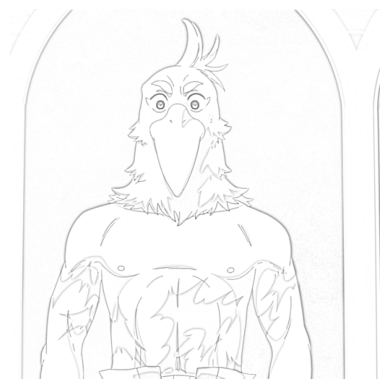

In [44]:
viewTensor(x)

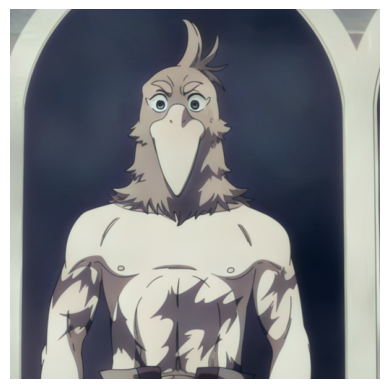

In [45]:
viewTensor(output.sample)

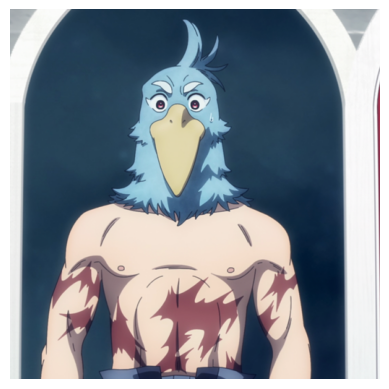

In [46]:
viewTensor(y)

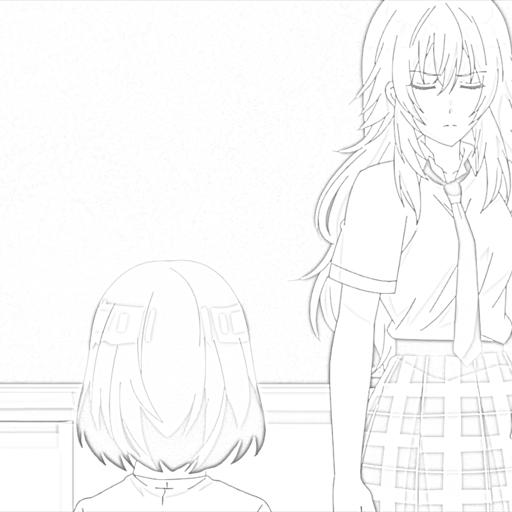

In [40]:
input_image, output_image = test_dataset.viewImage(idx)
input_image

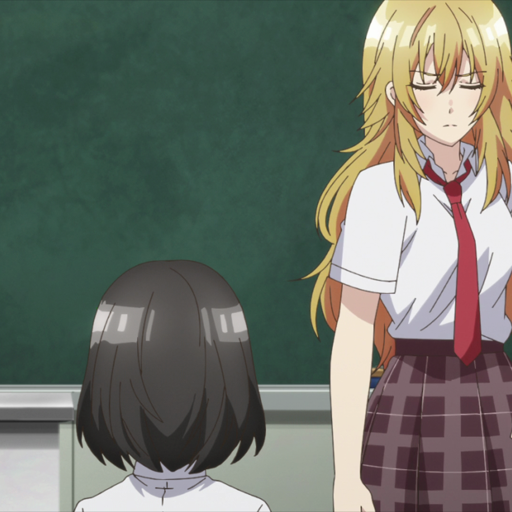

In [41]:
output_image

In [35]:
# pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2")
# encoder = pipe.vae.encoder
# decoder = pipe.vae.decoder

# x, y = training_dataset[100]
# model.eval()
# output = model(x.unsqueeze(0))

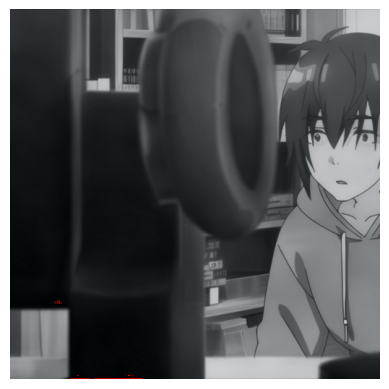

In [36]:
viewTensor(output.sample)

In [ ]:
items = list(output.items())

In [61]:
_, image = items[0]

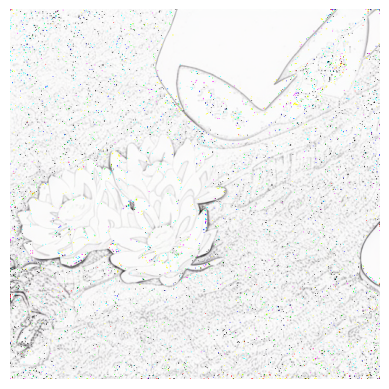

In [62]:
viewTensor(image)

In [56]:
image.shape

torch.Size([1, 3, 512, 512])